# Reduce Pollution 

This notebook outlines the general workflow for the data within the [Reduce Pollution](https://oceancentral.org/track/reduce-pollution) page of the Ocean Central website.

## Light pollution

For the raw light pollution files, data were downloaded from [here](https://doi.pangaea.de/10.1594/PANGAEA.969081) as 11 regional netcdf files per each month in 2019 (corresponding to 132 netcdf files total). The files for each month were merged together with `xarray` functions.

### Figure 1

In [ ]:
import xarray as xr

# Open all ALAN light pollution data for 2019 as an xarray dataset
combined = xr.open_mfdataset("../Data/ALAN/global_month_*.nc")

# Create a risk_level boolean based on what's considered a 'High' threat level (critical depth > 10)
combined['risk_level'] = (combined['z_thresh'] >= 10) #.astype(int)

# Drop the 'z_thresh' variable from the dataset
combined = combined.drop_vars('z_thresh')
combined

In [ ]:
import geopandas as gpd

# Open EEZ shapefiles
eez = gpd.read_file('../Data/World_EEZ_v12_20231025/eez_v12.shp')
eez

In [ ]:
import numpy as np
import geopandas as gpd
import rioxarray

# Open the biodiversity priority areas based on Zhao et al. 2020 (https://www.sciencedirect.com/science/article/abs/pii/S0006320719312182?via%3Dihub)
masked_data = rioxarray.open_rasterio('masked_top_30_percent_over_water.tif')

# Set the CRS for masked_data if it's not already set
if 'crs' not in masked_data.attrs:
    masked_data.rio.write_crs('EPSG:4326', inplace=True)

# Iterate over each country's EEZ and calculate the area where light pollution exceeds the 'High' threat level for at least one month in 2019
area_light_data = []
for i, row in eez.iterrows():
    try:
        print(i)
        country_name = row['TERRITORY1']
        geom = row['geometry']
        ISO_TER1 = row['ISO_TER1']
    
        # Rename dimensions if necessary
        if 'x' not in combined.dims or 'y' not in combined.dims:
            combined = combined.rename({'lon': 'x', 'lat': 'y'})
            combined.rio.write_crs('EPSG:4326', inplace=True)
        
        # Mask light pollution data with the selected EEZ geometry
        masked_light = combined.rio.clip([geom], drop=True)
    
        # Interpolate biodiversity priority areas to the same resolution as the light pollution data
        masked_data_interp = masked_data.interp(
            x=combined['x'],
            y=combined['y'],
            method='nearest'
        )
    
        lat = masked_light['y'].values
        lon = masked_light['x'].values
        
        # Calculate grid cell area
        lat_rad = np.deg2rad(lat)
        lon_rad = np.deg2rad(lon)
        
        R = 6371  # Earth radius in kilometers
        dlat = np.gradient(lat_rad)
        dlon = np.gradient(lon_rad)
        
        # Create a numpy array with approximate area calculation
        cell_areas = (R**2 * np.outer(np.sin(dlat), dlon)) * np.cos(lat_rad[:, None])
    
        # Ensure that cell_areas corresponds to the valid area in masked_light
        valid_cell_areas = np.where(masked_light.values, cell_areas, 0)
    
        # Compute the area impacted by 'High' threat light pollution
        area_light = (masked_light.max(dim='time')['risk_level'] * valid_cell_areas).sum().values
        
        # Calculate total masked area within the selected EEZ
        area_eez = valid_cell_areas.sum()
    
        # Create a mask for non-NaN values in masked_data_interp
        valid_mask_data = masked_data_interp
    
        # Compute the total area where both light pollution is under 'High' threat and it's within a priority area for a given EEZ
        area_biodiversity = ((masked_light.max(dim='time')['risk_level'] * valid_cell_areas) * valid_mask_data).sum().values
        
        # Store the result
        area_light_data.append({
            'Country': country_name,
            'ISO_TER1': ISO_TER1,
            'geometry': geom,
            'Light_Area': row['AREA_KM2']*area_light/area_eez, 
            'Light_Area_Percent': 100*area_light/area_eez, 
            'EEZ_Area': row['AREA_KM2'],
            'Biodiversity_Area': row['AREA_KM2']*area_biodiversity/area_eez,
            'Biodiversity_Area_Percent': 100*area_biodiversity/area_eez
        })
        print(country_name,'Light_Area:', row['AREA_KM2']*area_light/area_eez,'EEZ_Area:', row['AREA_KM2'],'Biodiversity_Area:', row['AREA_KM2']*area_biodiversity/area_eez)
    except Exception as e:
        print(e)

# Convert the results to a GeoDataFrame for easy viewing
area_light_gdf = gpd.GeoDataFrame(area_light_data, crs=eez.crs)

In [ ]:
print("Global area within EEZs impacted by high threat light pollution (Fig 1 data):", area_light_gdf['Light_Area'].sum()) 

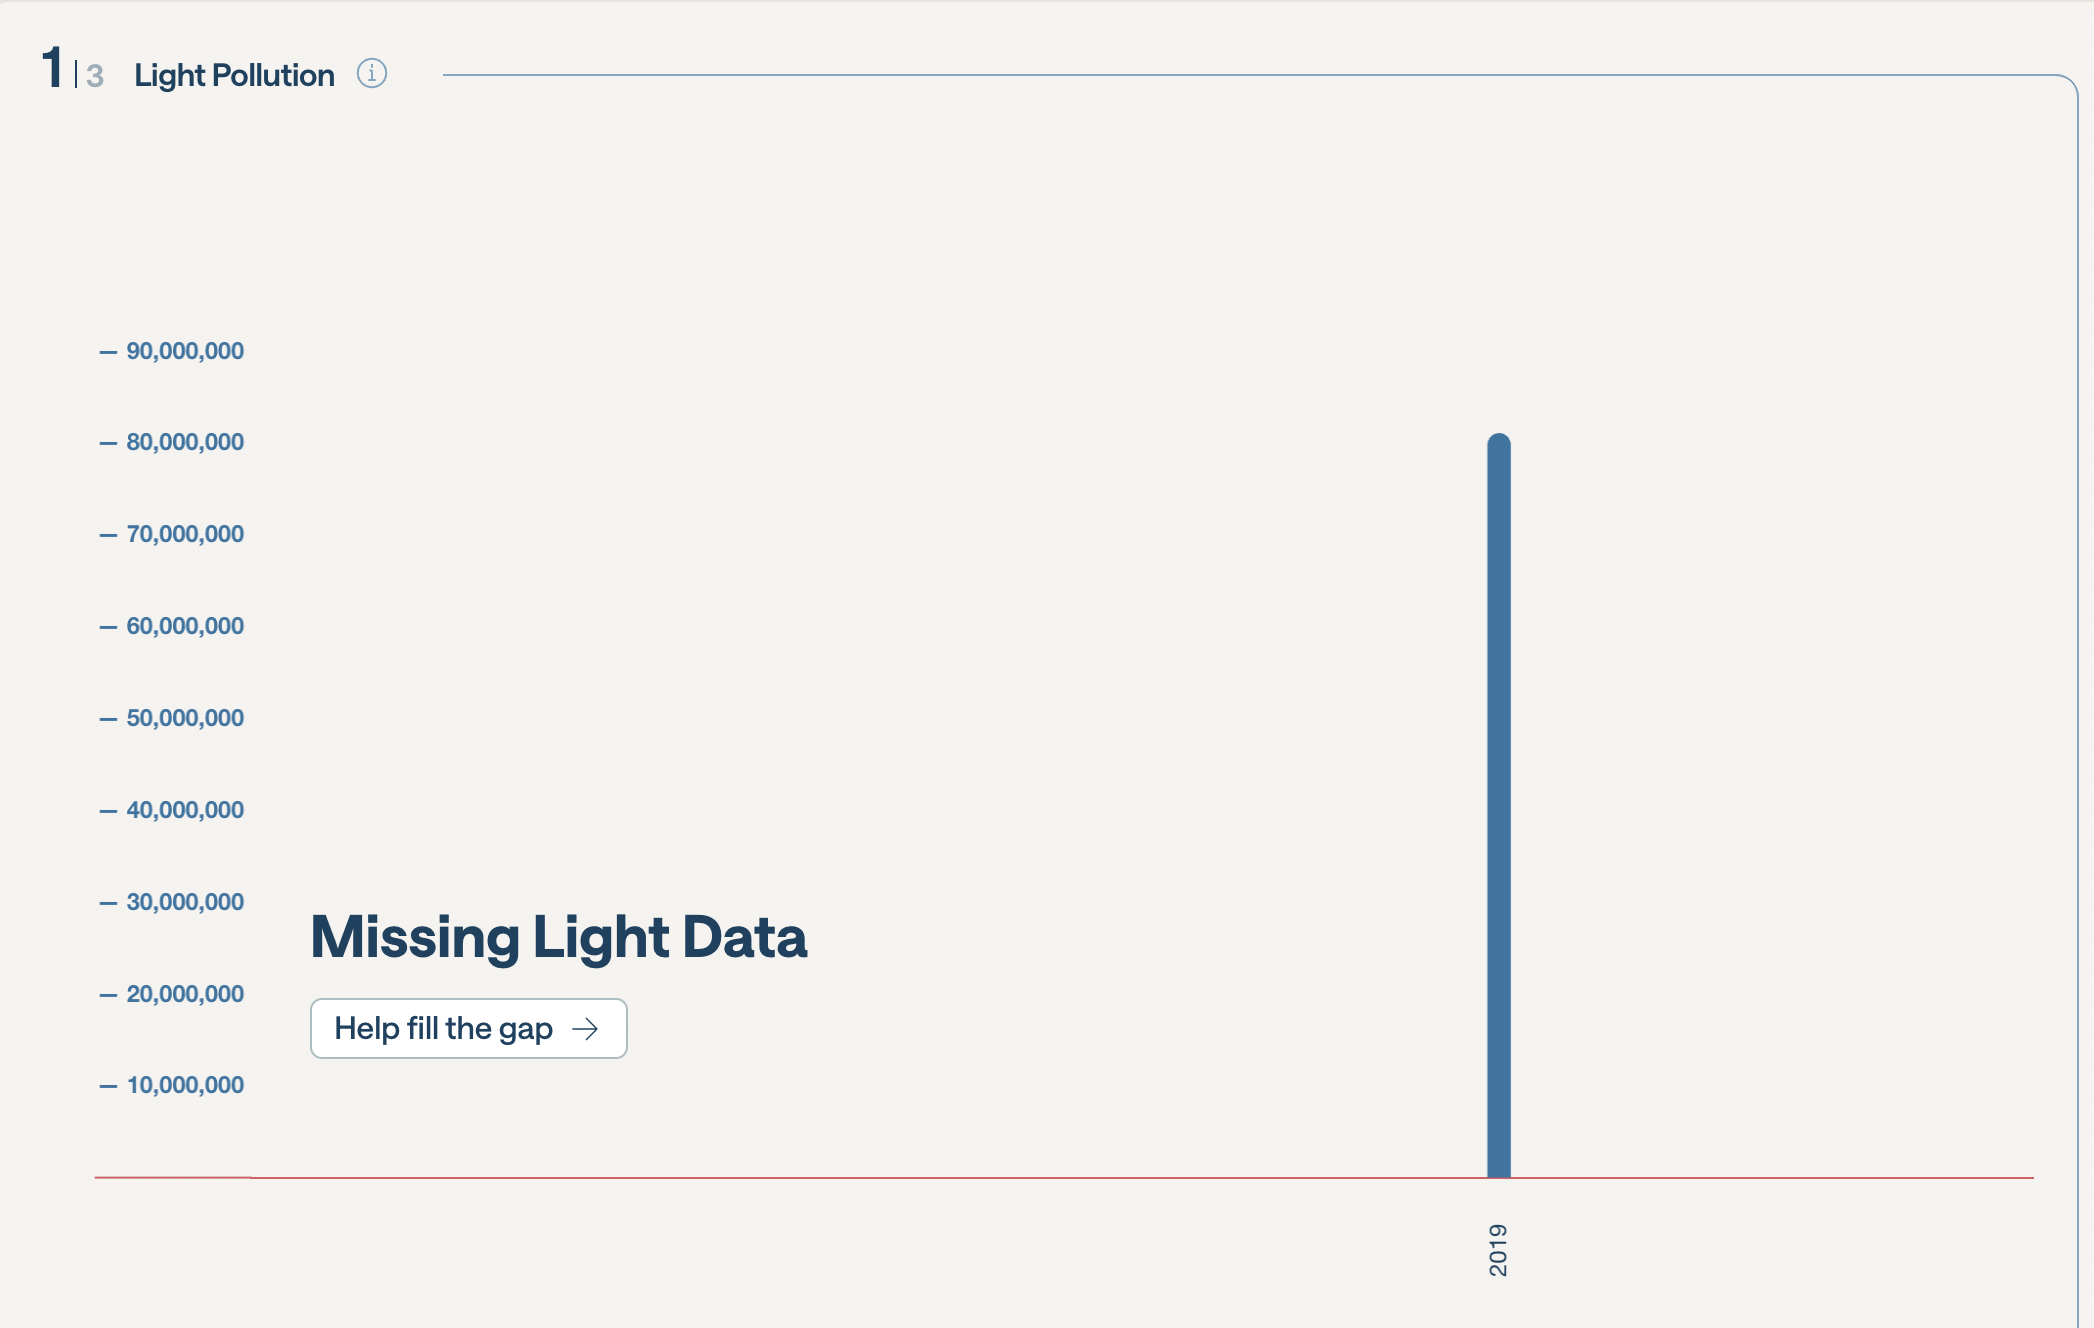

### Figure 3

In [ ]:
# Save the GeoDataFrame to a CSV file
area_light_gdf[['Country', 'ISO_TER1', 'Light_Area', 'EEZ_Area', 'Biodiversity_Area']].to_csv("../Data/pollution_3_light.csv", index=False)

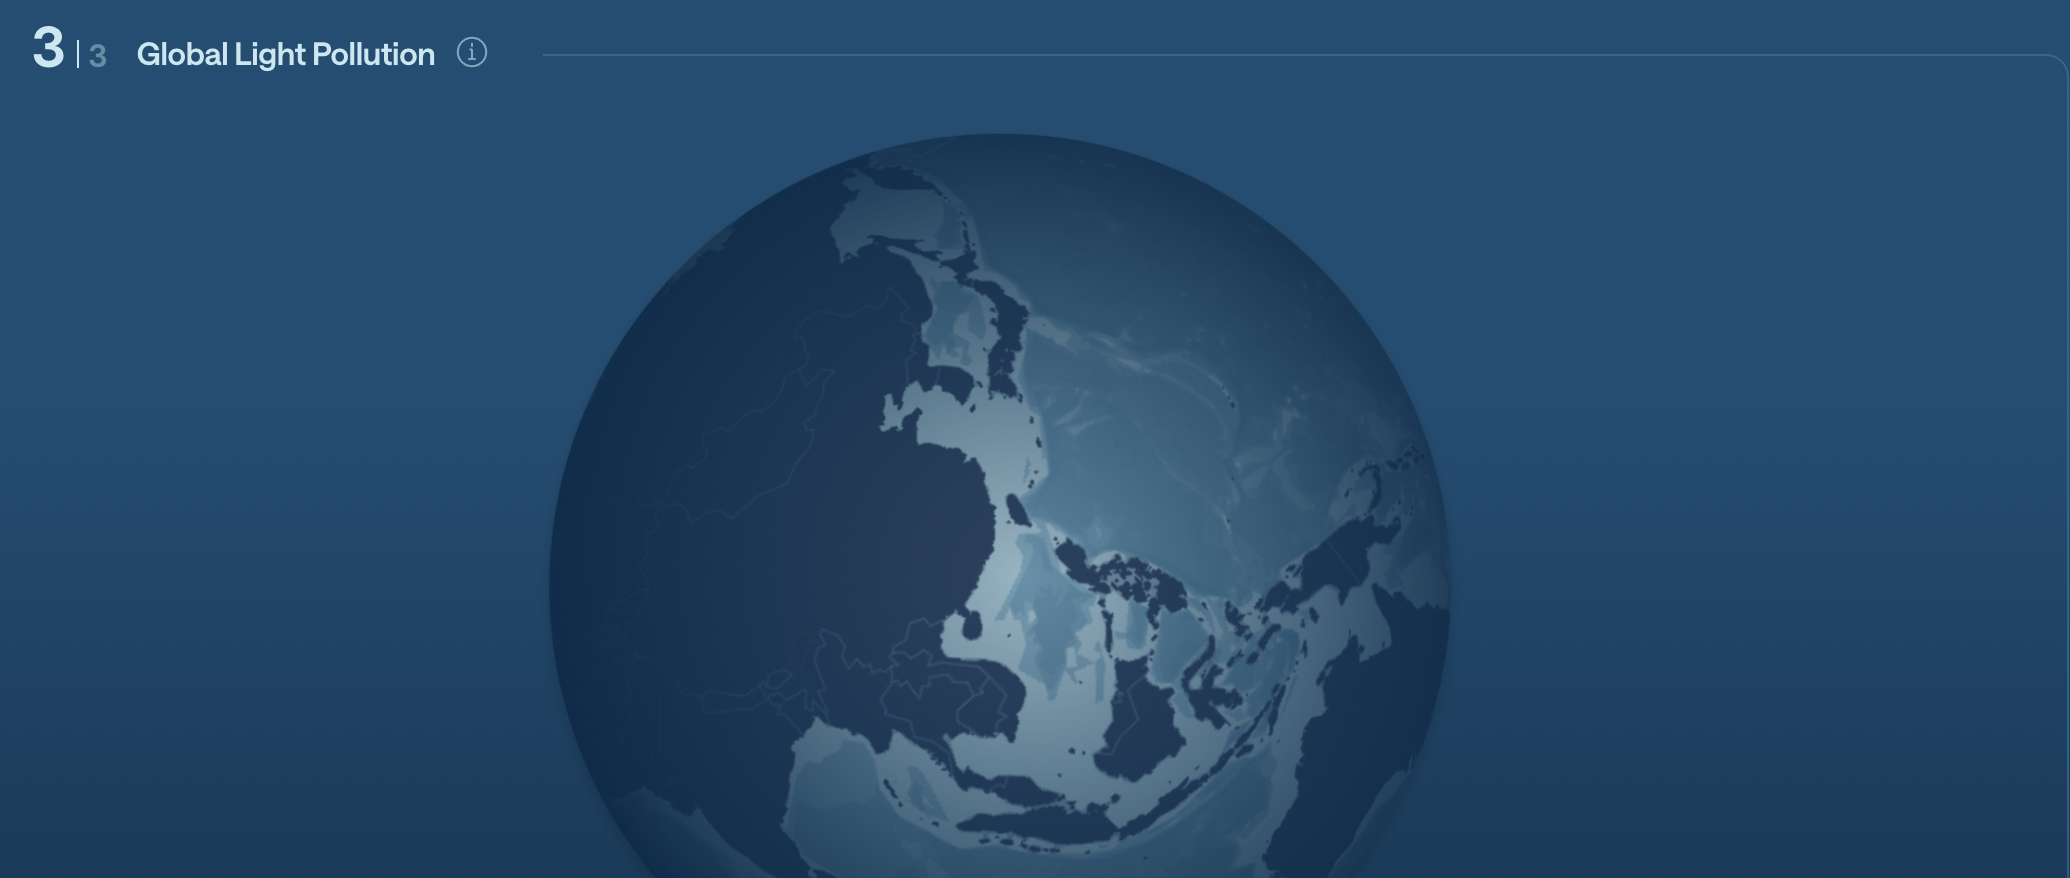

## Plastic pollution

### Figure 1

Data were obtained from OECD (2022) – processed by Our World in Data and can be found [here](https://ourworldindata.org/grapher/plastic-waste-accumulated-in-oceans).

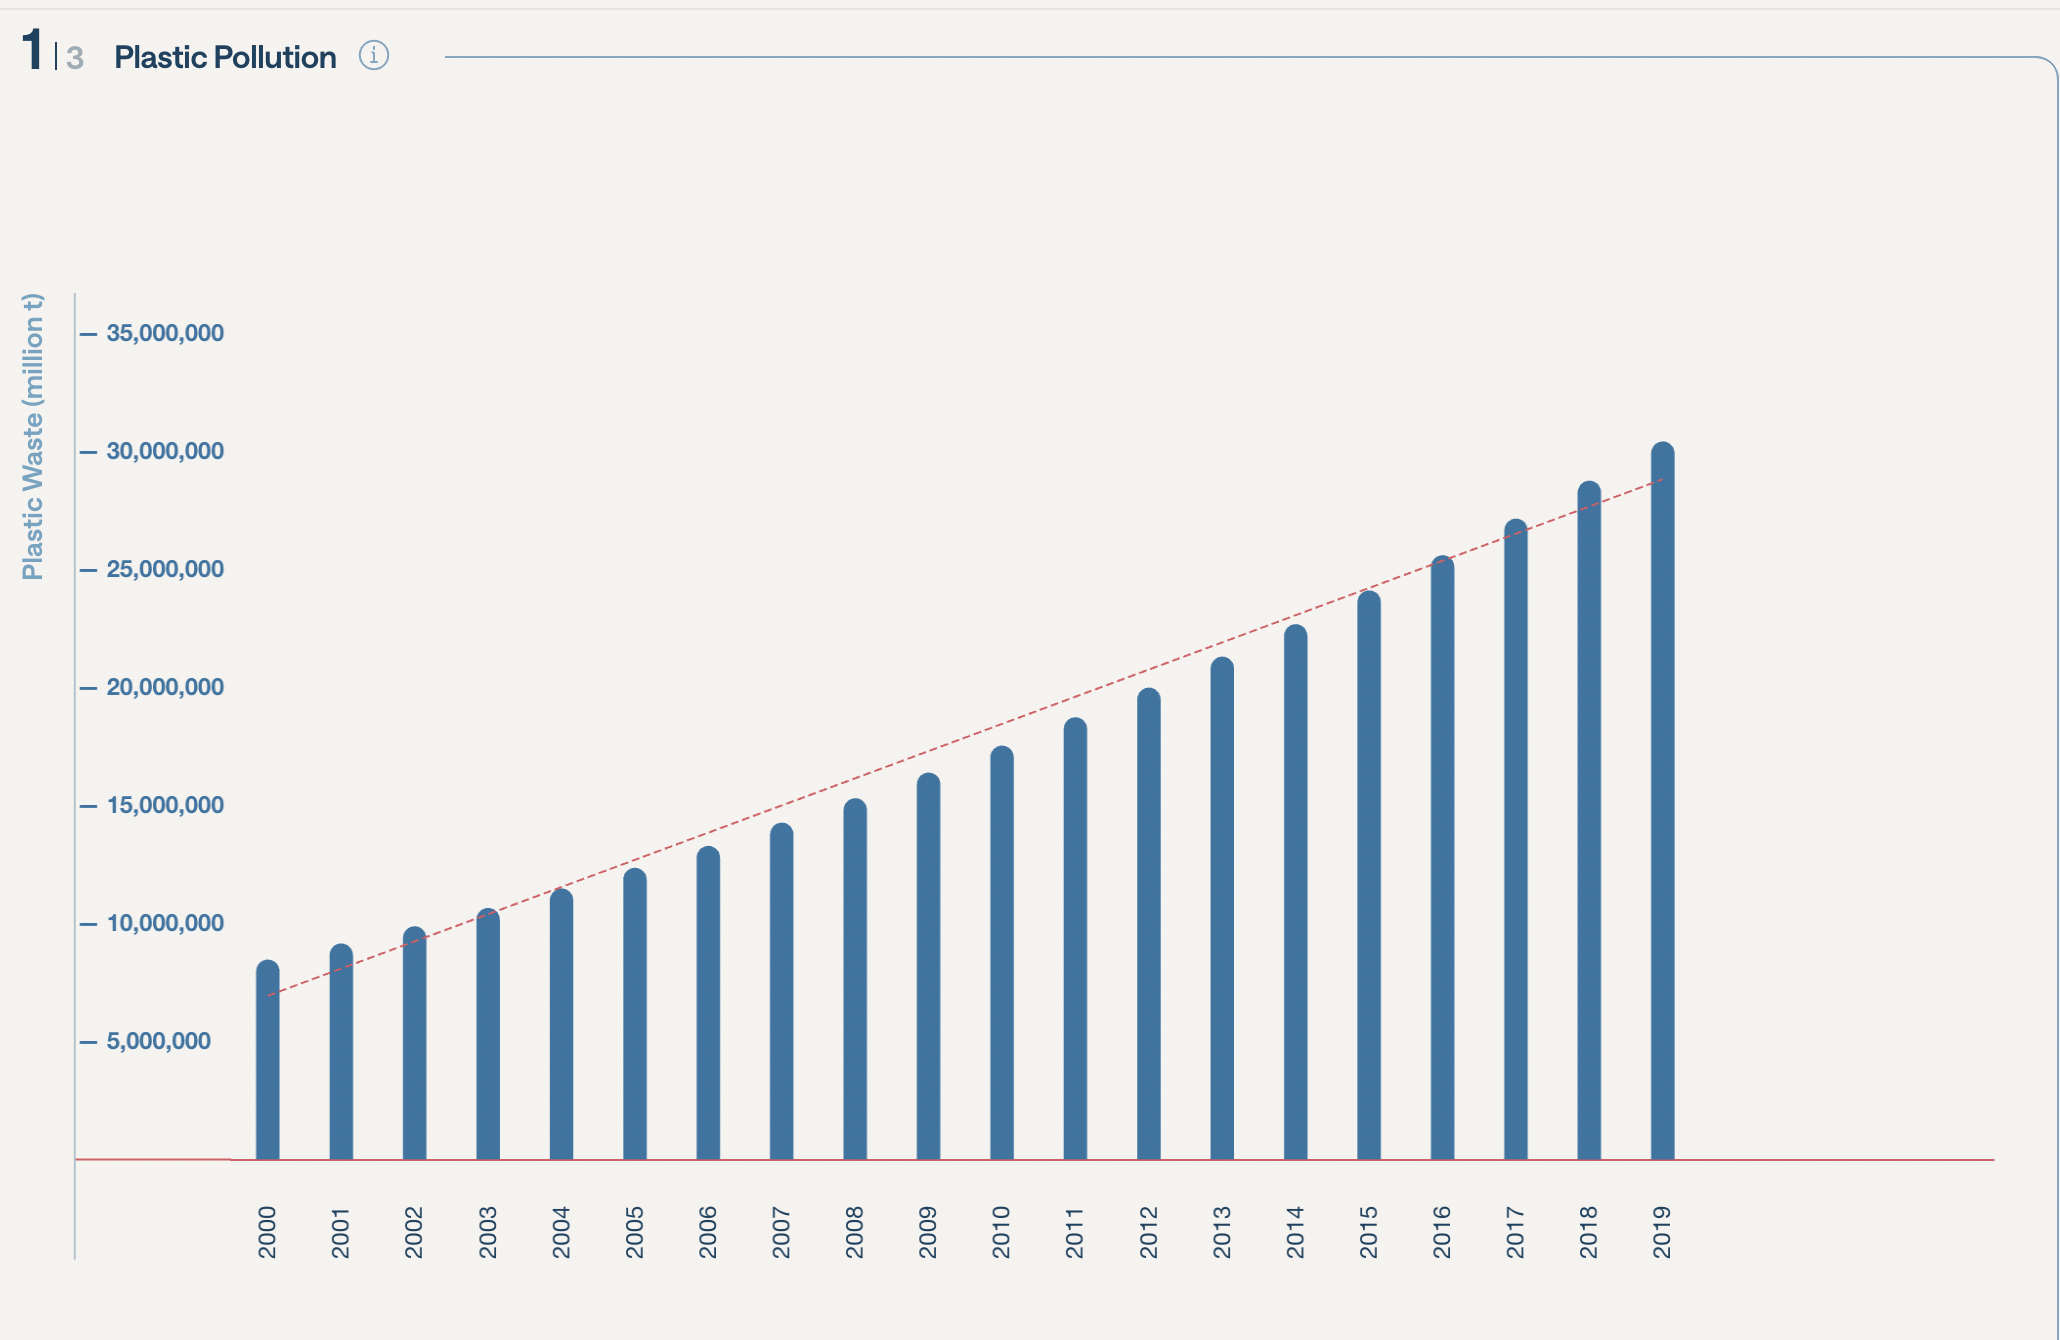

### Figure 2

Data were obtained from OECD (2022) – processed by Our World in Data and can be found [here](https://ourworldindata.org/grapher/plastic-production-by-sector).

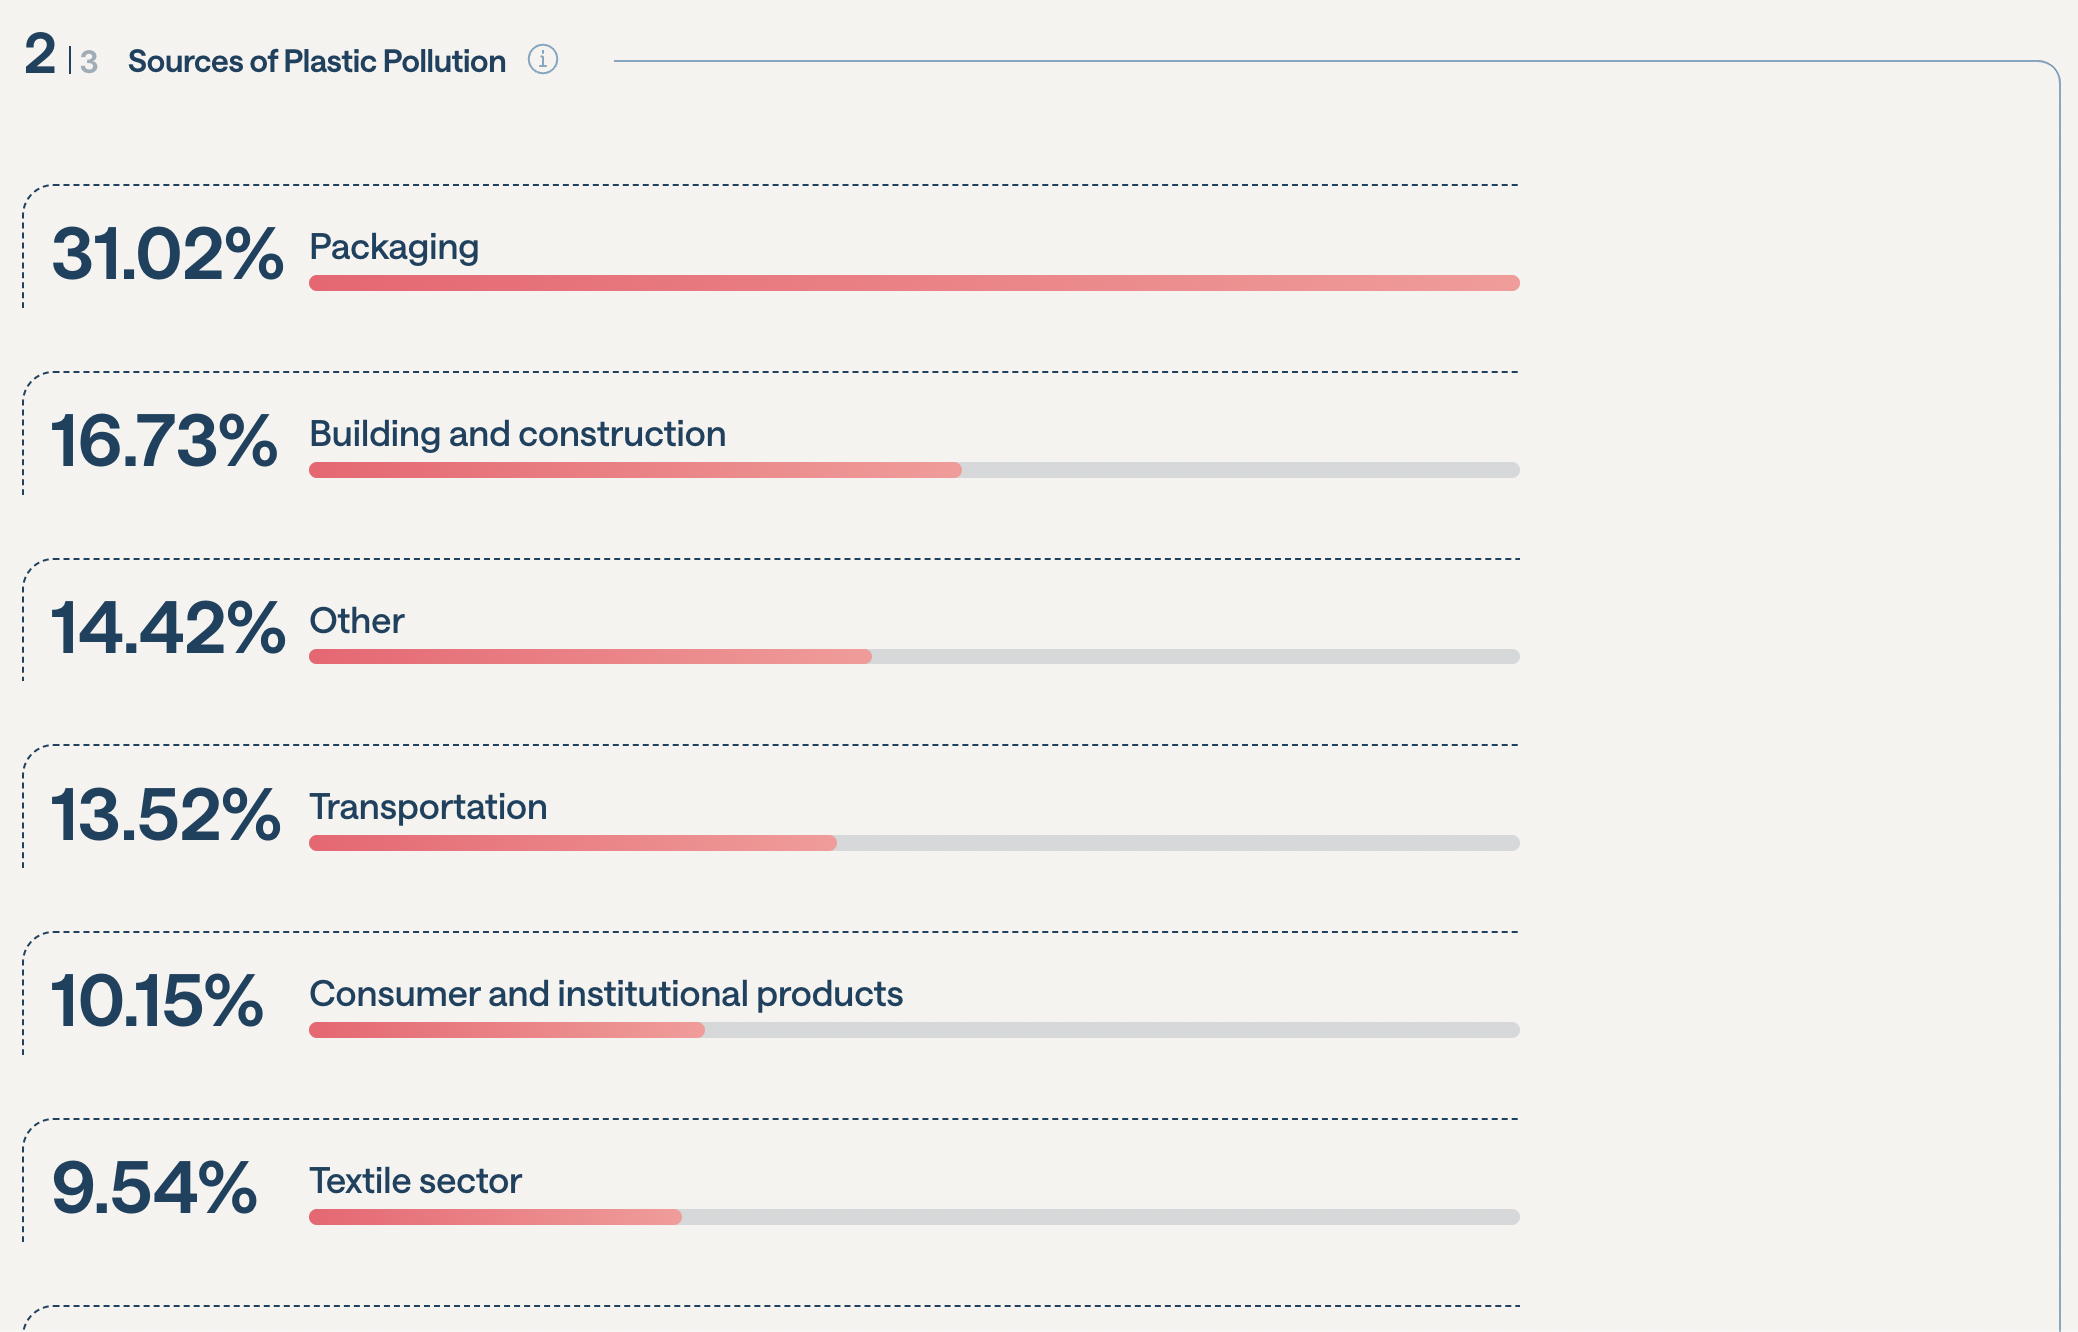

## CO<sub>2</sub>

### Figure 1

Coming soon...

### Figure 3

This code calculates trends of surface partial pressure of $CO_2$ in water data (spco2) and aggregates them at the level of water bodies throughout the world's oceans and seas. This is also overlaid with biodiversity priority areas from Zhao et al. (2020).  

In [ ]:
# Utils functions and globals 

import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import cartopy.crs as ccrs
from shapely.geometry import box
import rioxarray
import re

from rasterio.features import geometry_mask
from scipy.stats import linregress

# Open the biodiversity priority areas based on Zhao et al. 2020 (https://www.sciencedirect.com/science/article/abs/pii/S0006320719312182?via%3Dihub)
masked_data = rioxarray.open_rasterio('masked_top_30_percent_over_water.tif')

# Set the CRS for masked_data if it's not already set
if 'crs' not in masked_data.attrs:
    masked_data.rio.write_crs('EPSG:4326', inplace=True)

# Load global seas shapefile
seas_shapefile_path = '../Data/World_Seas_IHO_v3/World_Seas_IHO_v3.shp'
SEAS_DF = gpd.read_file(seas_shapefile_path)

# Calculate linear trend and p-value for each grid point
def calculate_trend_and_significance(x):
    if np.isnan(x).all():
        return np.nan, np.nan, np.nan
    else:
        slope, intercept, _, p_value, _ = stats.linregress(range(len(x)), x)
        return slope, intercept, p_value

# Calculate the trend and significance of the trend at each pixel in an xarray dataset
def calculate_trend_df(climate_df):
    df_mean = climate_df.groupby('time.year').mean()
    
    # Apply the trend and p-value calculation to the entire dataset
    results = xr.apply_ufunc(
        calculate_trend_and_significance,
        df_mean,
        input_core_dims=[['year']],
        vectorize=True,
        output_core_dims=[[], [], []],
        output_dtypes=[float, float, float]
    )
    
    # Extract the trend and p-value into separate DataArrays
    trends_da = xr.DataArray(results[0], coords=df_mean.isel(year=0).coords, name='trend')
    pvalues_da = xr.DataArray(results[2], coords=df_mean.isel(year=0).coords, name='p_value')
    
    # Create a significance mask where p-value < 0.05
    significant_da = xr.DataArray((pvalues_da < 0.05), coords=pvalues_da.coords, name='significant')
    
    # Combine trend, p-value, and significance mask into a single dataset
    trend_significance_ds = xr.Dataset({
        'trend': trends_da,
        'p_value': pvalues_da,
        'significant': significant_da
    })
    
    # Set the CRS for the trends dataset to match the EEZ CRS
    trend_significance_ds = trend_significance_ds.rio.write_crs("epsg:4326")
    return trend_significance_ds

# Calculate area-weighted trend, significance for each sea/ocean area
def area_trend(trend_significance_ds, SEAS_DF=SEAS_DF):
    # Iterate over each sea/ocean area and calculate the area-weighted trend and significant area percentage
    area_weighted_trends = []
    
    # Check if 'lat' and 'lon' are in the dataset, otherwise check for 'latitude' and 'longitude'
    if 'lat' in trend_significance_ds.dims and 'lon' in trend_significance_ds.dims:
        trend_significance_ds = trend_significance_ds.rename({'lat': 'y', 'lon': 'x'})
    elif 'latitude' in trend_significance_ds.dims and 'longitude' in trend_significance_ds.dims:
        trend_significance_ds = trend_significance_ds.rename({'latitude': 'y', 'longitude': 'x'})


    # Interpolate biodiversity priority areas to the same resolution as the climate data
    masked_data_interp = masked_data.interp(
        x=trend_significance_ds['x'],
        y=trend_significance_ds['y'],
        method='nearest'
    )

    # Calculate the area for each grid cell (assumes lat/lon grid)
    lat = trend_significance_ds['y'].values
    lon = trend_significance_ds['x'].values
    
    # Calculate grid cell area using Haversine formula or by approximation
    lat_rad = np.deg2rad(lat)
    lon_rad = np.deg2rad(lon)
    
    # Earth radius in kilometers
    R = 6371
    dlat = np.gradient(lat_rad)
    dlon = np.gradient(lon_rad)
    
    # Approximate area calculation
    cell_areas = (R**2 * np.outer(np.sin(dlat), dlon)) * np.cos(lat_rad[:, None])
    
    for i, row in SEAS_DF.iterrows():
        try:
            region_name = row['NAME']
            area = row['area']
            geom = row['geometry']
    
            # Mask SST trends with the sea geometry
            masked_trends = trend_significance_ds['trend'].rio.clip([geom], drop=True)
            masked_significance = trend_significance_ds['significant'].rio.clip([geom], drop=True)
    
            # Clip cell_areas to the same extent as masked_trends
            cell_areas_clipped = xr.DataArray(
                cell_areas, 
                dims=['y', 'x'], 
                coords={'y': trend_significance_ds['y'], 'x': trend_significance_ds['x']}
            )
            
            # Set CRS for cell_areas_clipped to match the CRS of trend_significance_ds
            cell_areas_clipped = cell_areas_clipped.rio.write_crs('EPSG:4326')
    
            # Clip cell_areas to the same geometry
            cell_areas_clipped = cell_areas_clipped.rio.clip([geom], drop=True)
        
            # Compute the area-weighted trend
            weighted_trend = (masked_trends * cell_areas_clipped).sum(dim=('y', 'x')) / cell_areas_clipped.sum()
    
            # Compute the total area that is significant
            significant_masked_areas = (masked_significance * cell_areas_clipped).where(masked_significance, 0)
            total_significant_area = significant_masked_areas.sum(dim=('y', 'x')).item()
    
            # Calculate the percentage of the area that is significant
            total_area = cell_areas_clipped.sum()
            significant_area_percent = (total_significant_area / total_area.item()) * 100
    
            # Calculate the area for biodiversity based on the mask
            area_biodiversity = ((masked_significance * cell_areas_clipped) * masked_data_interp).sum(dim=['x', 'y']).values
            area_biodiversity_percent = (area_biodiversity / total_area.item()) * 100
    
            # Store the result
            area_weighted_trends.append({
                'Region_Name': region_name,
                'geometry': geom,
                'Weighted_Trend': weighted_trend.item(),
                'Sea_Area': area,
                'Significant_Area': area*total_significant_area/total_area.item(),
                'Significant_Area_Percent': significant_area_percent,
                'Biodiversity_Area': area*area_biodiversity[0]/total_area.item(),
                'Biodiversity_Area_Percent': area_biodiversity_percent[0]
            })
        except Exception as e:
            print(e)

    # Convert the results to a GeoDataFrame for easy viewing
    area_weighted_trends_gdf = gpd.GeoDataFrame(area_weighted_trends, crs=SEAS_DF.crs)
    return area_weighted_trends_gdf


In [ ]:
co2_df = xr.open_dataset("~/Downloads/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc")

trend_significance_ds = calculate_trend_df(co2_df['spco2'])

area_df = area_trend(trend_significance_ds)

# Save the GeoDataFrame to a GeoJSON file
area_df.to_file("../Data/pollution_3_co2.geojson",driver="GeoJSON")

In [ ]:
area_df

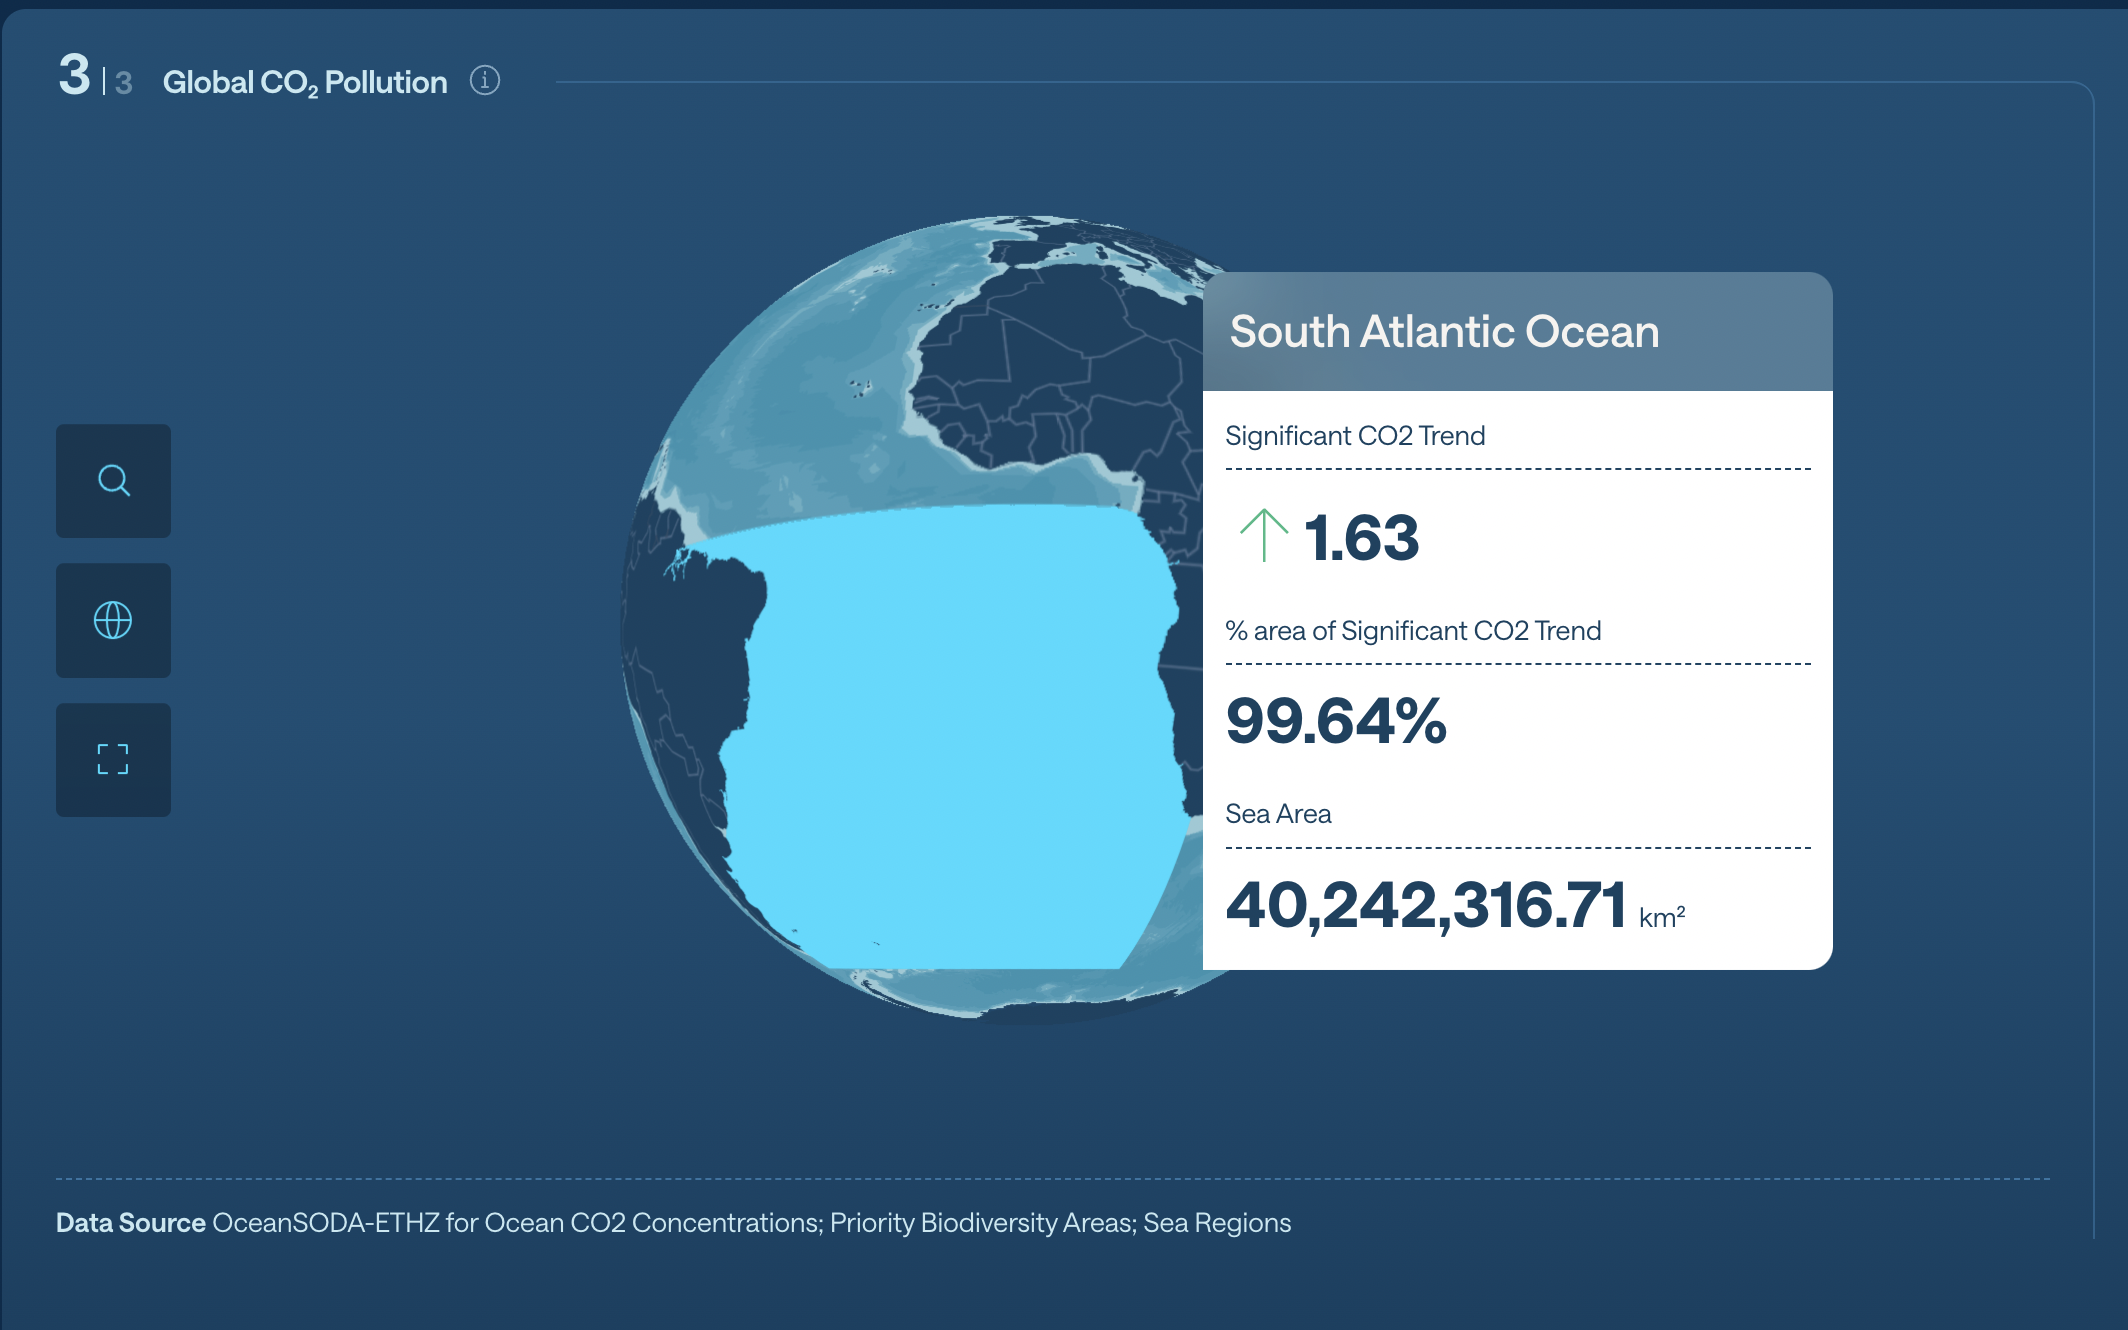

## Nutrient Pollution

### Figure 1

Coming soon.

### Figure 2

Coming soon.

### Figure 3

This code finds ocean dead zones based on modeled dissolved $O_2$ concentrations from the Global Ocean Biogeochemistry Analysis and Forecast from [Copernicus](https://doi.org/10.48670/moi-00015). Hypoxic conditions were defined as locations where the dissolved $O_2$ concentration is below 2 mg/L for any locations between the sea surface and 200m depth. The dead zones are then aggregated at the level of water bodies throughout the world's oceans and seas. This is also overlaid with biodiversity priority areas from Zhao et al. (2020).  

In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import cartopy.crs as ccrs
from shapely.geometry import box
import rioxarray
import re

from rasterio.features import geometry_mask
from scipy.stats import linregress
from tqdm import tqdm

# Open the biodiversity priority areas based on Zhao et al. 2020 (https://www.sciencedirect.com/science/article/abs/pii/S0006320719312182?via%3Dihub)
masked_data = rioxarray.open_rasterio('masked_top_30_percent_over_water.tif')

# Set the CRS for masked_data if it's not already set
if 'crs' not in masked_data.attrs:
    masked_data.rio.write_crs('EPSG:4326', inplace=True)

# Load SST dataset and EEZ shapefile
seas_shapefile_path = '../Data/World_Seas_IHO_v3/World_Seas_IHO_v3.shp'
SEAS_DF = gpd.read_file(seas_shapefile_path)

def area_dead_zone(o2_df, SEAS_DF=SEAS_DF):
    area_deadzone = []

    # Set CRS and rename dimensions and coordinates
    o2_df = o2_df.rio.write_crs("epsg:4326")
    o2_df = o2_df.rename({'latitude': 'y', 'longitude': 'x'})

    # Interpolate biodiversity priority areas to the same resolution as the climate data
    masked_data_interp = masked_data.interp(
        x=o2_df['x'],
        y=o2_df['y'],
        method='nearest'
    )

    # Calculate the area for each grid cell (assumes lat/lon grid)
    lat = o2_df['y'].values
    lon = o2_df['x'].values
    
    # Calculate grid cell area using Haversine formula or by approximation
    lat_rad = np.deg2rad(lat)
    lon_rad = np.deg2rad(lon)
    
    # Earth radius in kilometers
    R = 6371
    dlat = np.gradient(lat_rad)
    dlon = np.gradient(lon_rad)
    
    # Approximate area calculation
    cell_areas = (R**2 * np.outer(np.sin(dlat), dlon)) * np.cos(lat_rad[:, None])
    
    # Use tqdm to track progress through SEAS_DF.iterrows()
    for i, row in tqdm(SEAS_DF.iterrows(), total=len(SEAS_DF), desc="Processing Sea Areas"):
        try:
            region_name = row['NAME']
            area = row['area']
            geom = row['geometry']
    
            # Mask SST trends with the sea geometry
            masked_df = o2_df.rio.clip([geom], drop=True)
    
            # Clip cell_areas to the same extent as masked_df
            cell_areas_clipped = xr.DataArray(
                cell_areas, 
                dims=['y', 'x'], 
                coords={'y': o2_df['y'], 'x': o2_df['x']}
            )
            
            # Set CRS for cell_areas_clipped to match the CRS of trend_significance_ds
            cell_areas_clipped = cell_areas_clipped.rio.write_crs('EPSG:4326')
    
            # Clip cell_areas to the same geometry
            cell_areas_clipped = cell_areas_clipped.rio.clip([geom], drop=True)
        
            # Compute the total area that is impacted by dead zones
            deadzone_area = (masked_df * cell_areas_clipped).sum(dim=('y', 'x')).compute()  # Compute to convert from Dask array
    
            # Calculate the area for biodiversity based on the mask
            area_biodiversity = ((masked_df * cell_areas_clipped) * masked_data_interp).sum(dim=['x', 'y']).compute()

            total_area = cell_areas_clipped.sum(dim=('y', 'x')).compute()  # Ensure computation
    
            # Extract values after computing
            deadzone_area_value = deadzone_area.item() if deadzone_area.size == 1 else deadzone_area.values[0]
            total_area_value = total_area.item() if total_area.size == 1 else total_area.values[0]
            area_biodiversity = area_biodiversity.item() if area_biodiversity.size == 1 else area_biodiversity.values[0]
    
            # Store the result
            area_deadzone.append({
                'Region_Name': region_name,
                'geometry': geom,
                'Deadzone_Area': area*deadzone_area_value/total_area.item(),
                'Deadzone_Area_Percent': 100*(deadzone_area_value/total_area.item()),
                'Sea_Area': area,
                'Biodiversity_Area': area*area_biodiversity/total_area.item(),
                'Biodiversity_Area_Percent': 100*(area_biodiversity/total_area.item()),
            })
        except Exception as e:
            print(f"Error processing {region_name}: {e}")

    # Convert the results to a GeoDataFrame for easy viewing
    area_deadzone_gdf = gpd.GeoDataFrame(area_deadzone, crs=SEAS_DF.crs)
    return area_deadzone_gdf

In [ ]:
# Load the dataset
o2_df = xr.open_mfdataset("../Data/dead_zone/*")

# Conversion factor from mmol O2/m³ to mg/L
o2_conversion_factor = 32 / 1000

# Convert oxygen concentration from mmol O2/m³ to mg/L
o2_mg_per_l = o2_df['o2'] * o2_conversion_factor

# Define a depth range for dead zone analysis (e.g., upper 200 meters)
shallow_depth_mask = o2_df['depth'] <= 200

# Apply the mask to limit analysis to shallow depths
o2_mg_per_l_shallow = o2_mg_per_l.where(shallow_depth_mask, drop=True)

# Create a mask where oxygen concentration is less than 2 mg/L at any shallow depth or time
low_oxygen_mask_shallow = (o2_mg_per_l_shallow < 2).max(dim=['depth', 'time']).astype(int)

area_df = area_dead_zone(low_oxygen_mask_shallow)

# Save the GeoDataFrame to a GeoJSON file
area_df.to_file("../Data/pollution_3_nutrients.geojson",driver="GeoJSON")

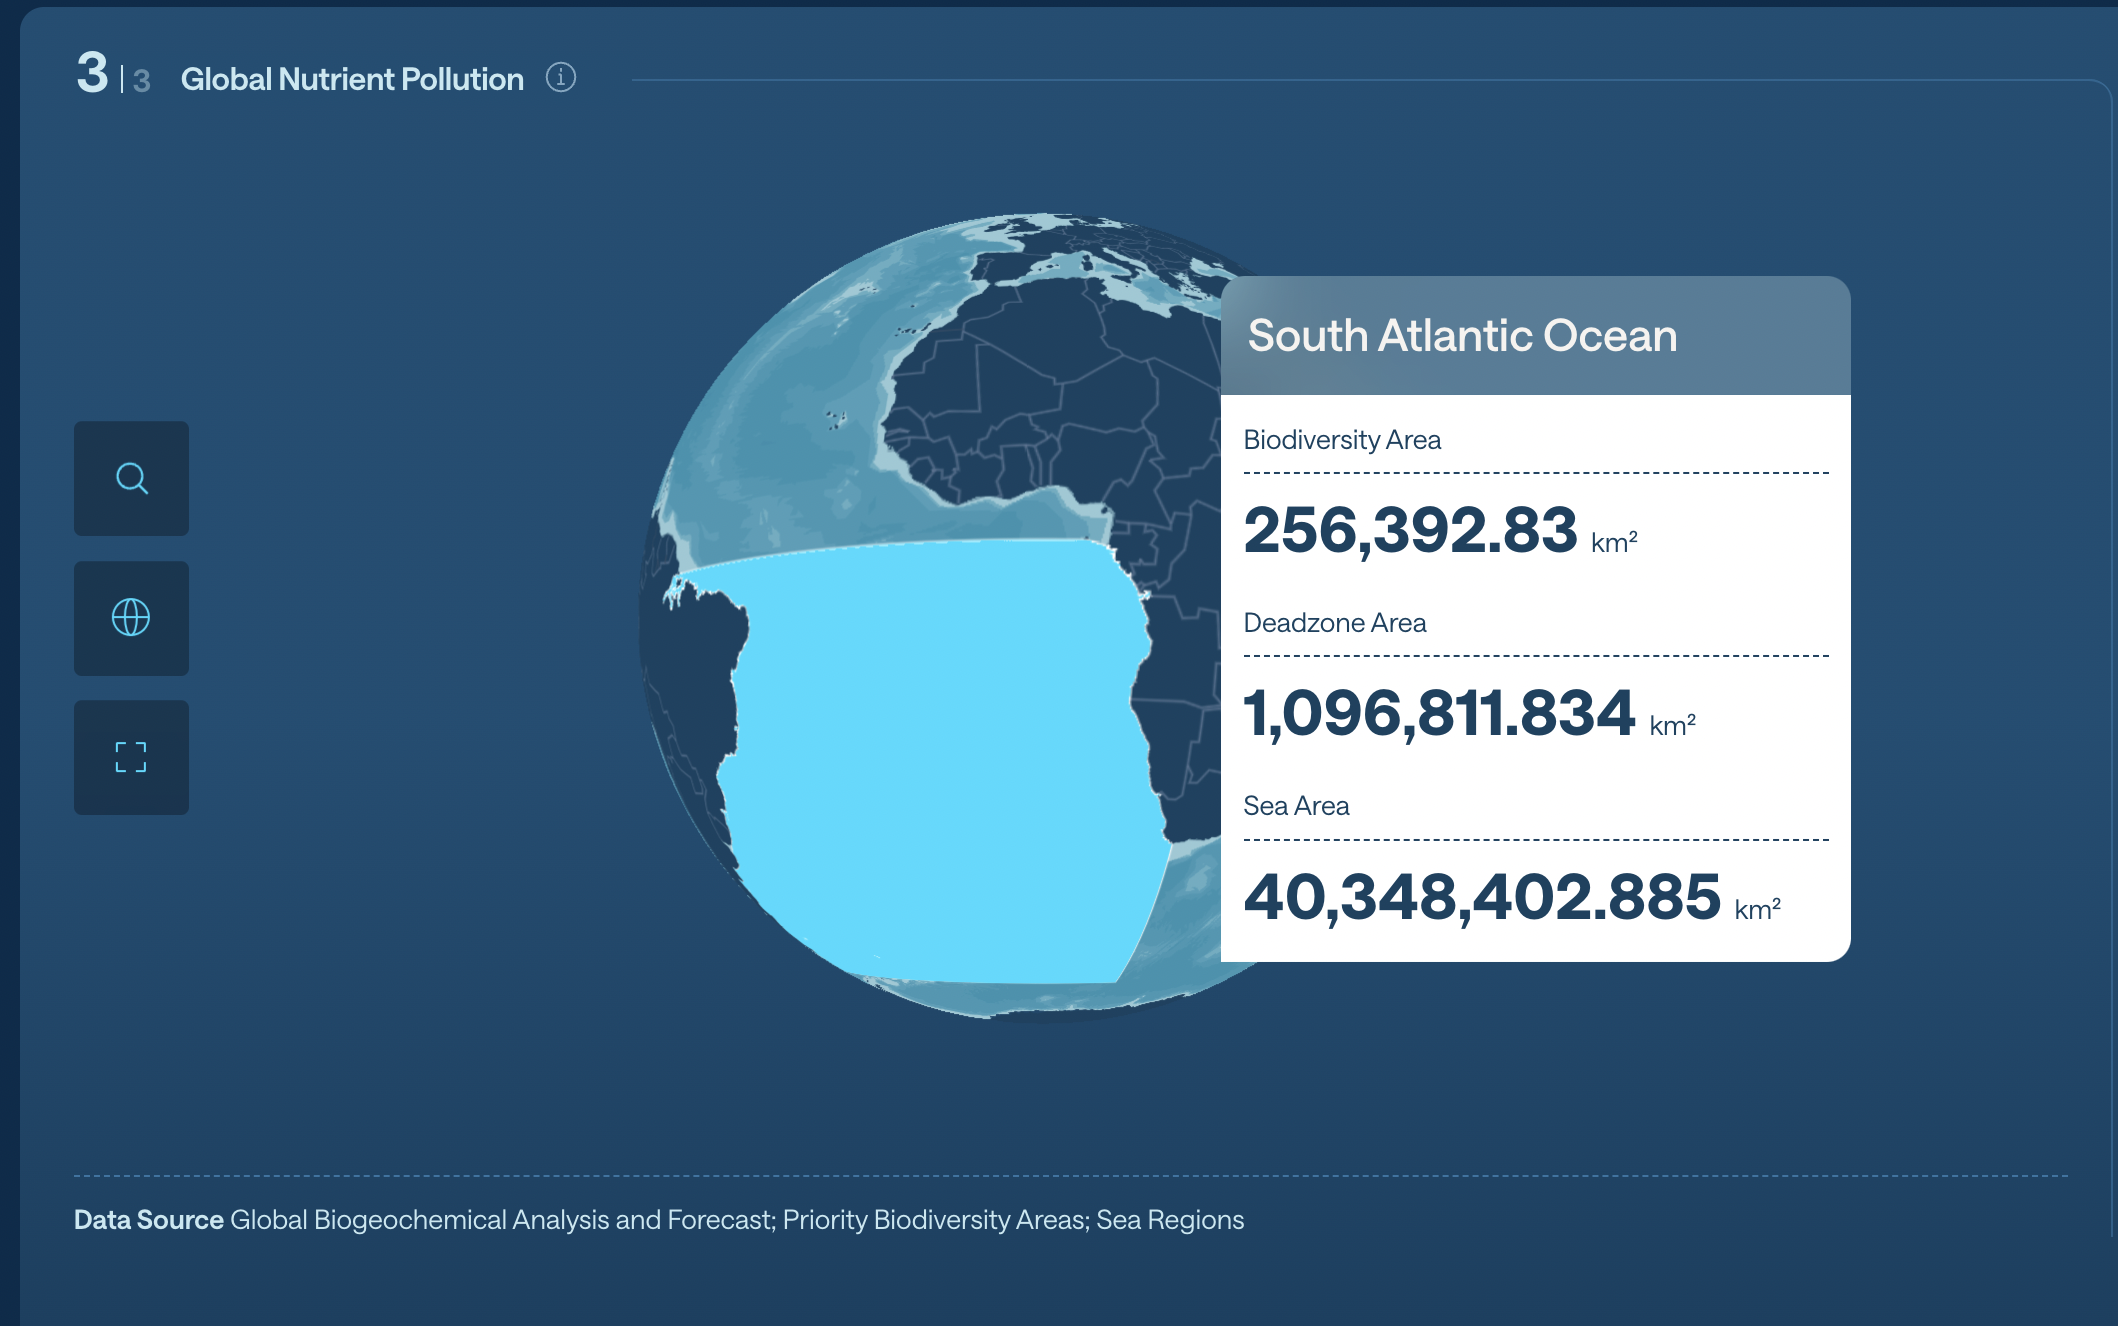